In [2]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [4]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

  01 WT_Mock 02 WT_RG.I 03 WT_flg22 04 efrfls2_Mock 05 efrfls2_RG.I
1   3.939928   3.872982    3.939928        3.939928        3.696890
2   3.696890   3.793800    3.793800        3.793800        3.395860
3   3.571952   3.395860    3.939928        3.571952        3.094830
4   3.395860   3.571952    3.395860        3.696890        3.571952
5         NA         NA          NA              NA              NA
6         NA         NA          NA              NA              NA
  06 efrfls2_flg22 07 WT_Mock.1 08 WT_RG.I.1 09 WT_flg22.1 10 efrfls2_Mock.1
1         3.939928     6.174012     5.997920      5.872982          7.939928
2         3.696890     6.270922     6.298950      5.872982          7.939928
3         3.997920     6.270922     6.373584      5.872982          7.872982
4         3.696890     6.373584     6.270922      5.793800          7.997920
5               NA     6.094830     5.872982      5.997920          7.571952
6               NA     6.696890     6.094830      5.571952    

# A tibble: 6 × 3
  Treatment  Trial   VALUE
  <chr>      <chr>   <dbl>
1 01 WT_Mock Trial01  3.94
2 01 WT_Mock Trial01  3.70
3 01 WT_Mock Trial01  3.57
4 01 WT_Mock Trial01  3.40
5 02 WT_RG.I Trial01  3.87
6 02 WT_RG.I Trial01  3.79


[1] 19 74

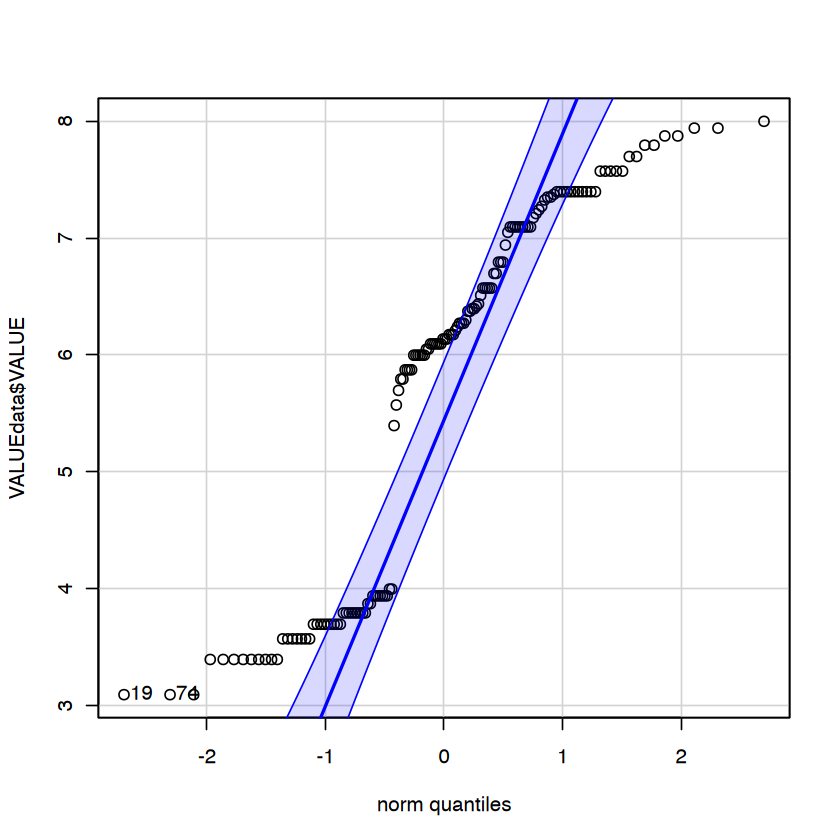

In [5]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

boundary (singular) fit: see help('isSingular')

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

      AIC       BIC    logLik -2*log(L)  df.resid 
     32.1      73.7      -2.1       4.1       130 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6832 -0.5390  0.0931  0.6821  3.3347 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept) 0.00000  0.0000  
 Residual             0.06025  0.2455  
Number of obs: 144, groups:  Trial, 2

Fixed effects:
                             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)                   3.53562    0.08678 144.00000  40.742   <2e-16 ***
Treatment02 WT_RG.I           0.06339    0.12273 144.00000   0.516   0.6063    
Treatment03 WT_flg22          0.24540    0.12273 144.00000   2.000   0.0474 *  
Treatment04 efrfls2_Mock      0.14701    0.12273 144.00000   1.198   0.2329    
Treatment05 efrfls2_RG.I     -0.03038    0

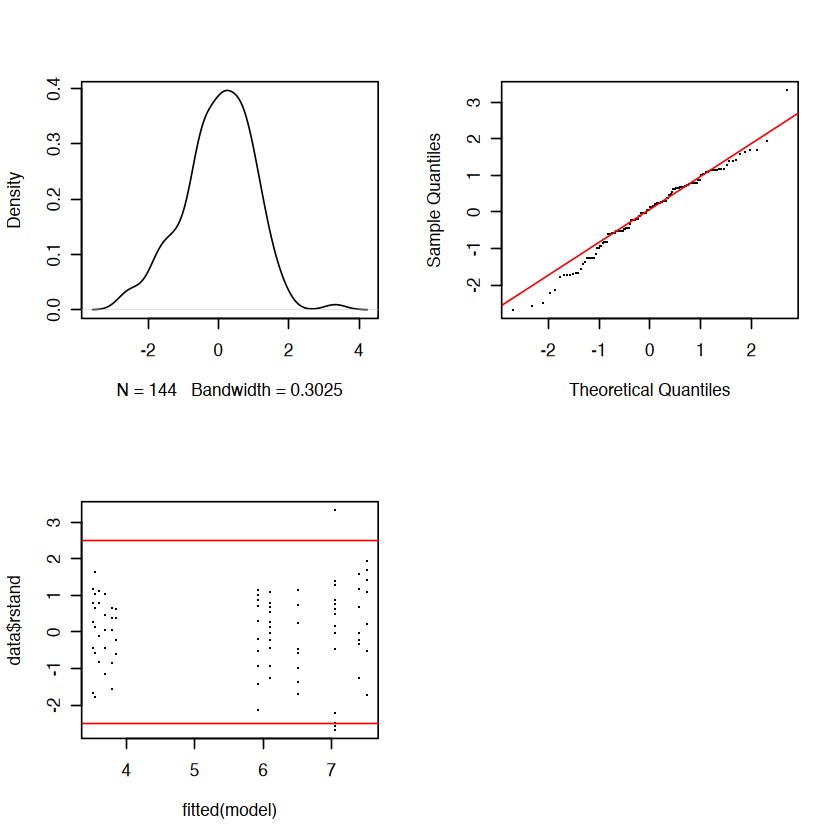

In [6]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [7]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq          NumDF        DenDF        F value     
 Min.   :343.8   Min.   :31.26   Min.   :11   Min.   :144   Min.   :518.8  
 1st Qu.:343.8   1st Qu.:31.26   1st Qu.:11   1st Qu.:144   1st Qu.:518.8  
 Median :343.8   Median :31.26   Median :11   Median :144   Median :518.8  
 Mean   :343.8   Mean   :31.26   Mean   :11   Mean   :144   Mean   :518.8  
 3rd Qu.:343.8   3rd Qu.:31.26   3rd Qu.:11   3rd Qu.:144   3rd Qu.:518.8  
 Max.   :343.8   Max.   :31.26   Max.   :11   Max.   :144   Max.   :518.8  
     Pr(>F)          
 Min.   :6.701e-110  
 1st Qu.:6.701e-110  
 Median :6.701e-110  
 Mean   :6.701e-110  
 3rd Qu.:6.701e-110  
 Max.   :6.701e-110  


Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”



	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                                            Estimate Std. Error z value
02 WT_RG.I - 01 WT_Mock == 0                 0.06339    0.12273   0.516
03 WT_flg22 - 01 WT_Mock == 0                0.24540    0.12273   2.000
04 efrfls2_Mock - 01 WT_Mock == 0            0.14701    0.12273   1.198
05 efrfls2_RG.I - 01 WT_Mock == 0           -0.03038    0.12273  -0.248
06 efrfls2_flg22 - 01 WT_Mock == 0           0.30940    0.12273   2.521
07 WT_Mock.1 - 01 WT_Mock == 0               2.97782    0.10629  28.017
08 WT_RG.I.1 - 01 WT_Mock == 0               2.56914    0.10629  24.172
09 WT_flg22.1 - 01 WT_Mock == 0              2.38799    0.10629  22.468
10 efrfls2_Mock.1 - 01 WT_Mock == 0          3.98613    0.10629  37.504
11 efrfls2_RG.I.1 - 01 WT_Mock == 0          3.51885    0.10629  33.

Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”
Warning message in RET$pfunction("adjusted", ...):
“Completion with error > abseps”


        01 WT_Mock         02 WT_RG.I        03 WT_flg22    04 efrfls2_Mock 
               "a"                "a"                "a"                "a" 
   05 efrfls2_RG.I   06 efrfls2_flg22       07 WT_Mock.1       08 WT_RG.I.1 
               "a"                "a"                "b"                "c" 
     09 WT_flg22.1  10 efrfls2_Mock.1  11 efrfls2_RG.I.1 12 efrfls2_flg22.1 
               "c"                "d"                "e"                "d" 
